In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR, LambdaLR
import sympy as sp

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [69]:
class Multi_Func(nn.Module):
    def __init__(self, functions, num_params, symbols, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.x_data = x_data.to(self.device)
        self.input_channels = input_channels
        self.num_params = num_params
        self.max_params = max(num_params)
        self.total_params = sum(self.num_params)
        self.symbols = symbols

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.total_params),
        )

    def evaluate(self, params, index):
        symbols = self.symbols[index]
        formula = self.functions[index]
        x = self.x_data
        var_values = {str(symbols[j]): params[:, j] for j in range(len(symbols)-1)}
        eval_func = sp.lambdify(symbols, formula, modules="numpy")
        var_values[str(symbols[-1])] = x.unsqueeze(1)
        results = eval_func(**var_values)
        results = torch.nan_to_num(results, 0)
        return results.swapaxes(0,1)

    def forward(self, inputs):
        target = inputs.squeeze(dim=2)
        outs = torch.swapaxes(inputs, 1, 2).to(self.device)
        outs = self.hidden_x1(outs)
        xfc = torch.reshape(outs, (-1, 256))
        xfc = self.hidden_xfc(xfc)

        outs = torch.reshape(outs, (-1, 2, 128))
        outs = self.hidden_x2(outs)
        cnn_flat = self.flatten_layer(outs)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        #loss_func = nn.MSELoss()
        start_index = 0
        losses = []
        outputs = []
        all_params = []
        
        for f in range(len(self.functions)):
            params = embedding[:, start_index:start_index+self.num_params[f]]
            all_params.append(F.pad(params, (0, self.max_params-self.num_params[f])))
            output = self.evaluate(params, f).to(self.device)
            outputs.append(output)
            loss = torch.mean(((target - output) ** 2), dim=1)
            losses.append(loss)
            start_index += self.num_params[f]        
        stacked_losses = torch.stack(losses).to(self.device)
        stacked_preds = torch.stack(outputs).to(self.device)
        best_loss, best_indexes = torch.min(stacked_losses, dim=0)
        best_out = stacked_preds[best_indexes, -1]
        best_func = [self.functions[idx] for idx in best_indexes]
        best_params = []
        for index, value in enumerate(best_indexes):
            best_params.append(all_params[value][index])
        return best_out, best_loss, best_func, best_indexes, torch.stack(best_params), stacked_preds, stacked_losses, all_params

In [34]:
loaded_data = torch.load('hold_data.pth')

x_values = loaded_data['x_values'].to(device)
y_values = loaded_data['y_values'].to(device)
derivatives = loaded_data['derivatives'].to(device)
params = loaded_data['param_values'].to(device)
functions = loaded_data['formulas']
symbols = loaded_data['symbols']
num_params = loaded_data['num_params'].to(device)
function_labels = loaded_data['function_labels'].to(device)
full_params = loaded_data['full_params'].to(device)

/tmp/ipykernel_1097109/3845502952.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load('hold_data.pth')


In [35]:
print(f"x_values: {x_values.shape}")
print(f"y_values: {y_values.shape}")
print(f"derivatives: {derivatives.shape}")
#print(f"hessians: {hessians.shape}")
print(f"param_values: {params.shape}")
print(f"formulas: {len(functions)}")
print(f"symbols: {len(symbols)}")
print(f"num_params: {num_params.shape}")
print(f"function_labels: {function_labels.shape}")
print(f"full_params: {full_params.shape}")

x_values: torch.Size([100])
y_values: torch.Size([10000, 100])
derivatives: torch.Size([10000, 100, 5])
param_values: torch.Size([10000, 5])
formulas: 10
symbols: 10
num_params: torch.Size([10])
function_labels: torch.Size([10000])
full_params: torch.Size([10000, 50])


In [36]:
input_data = y_values[0:2000, :].unsqueeze(2)
input_params = F.pad(params[0:2000, :], (0,  input_data.shape[1]-params.shape[1])).unsqueeze(2)
dataloader = DataLoader([input_data, input_params], batch_size=100, shuffle=True)

In [156]:
for z in dataloader:
    print(z[0].squeeze(2))

tensor([[ 0.2586,  0.5802,  0.1602,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7814,  0.5119,  0.9048,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1303, -0.4240, -0.1255,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.9933,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4759,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1164,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:3')


In [148]:
model = Multi_Func(functions[0:2], num_params, symbols, x_values, 1, device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
total_epochs = 100

'''def loss_func(output_y, target_y, output_params, target_params, lam):
    y_loss = torch.mean((output_y - target_y) ** 2)
    params_loss = torch.mean((output_params - target_params) ** 2)
    return y_loss*(1-lam) + params_loss*lam'''

def lambda_rule(epoch):
    start_lambda = 1*100
    end_lambda = 0
    return start_lambda - (start_lambda - end_lambda) * min(epoch / total_epochs, 1.0)

lambda_scheduler = LambdaLR(optimizer, lr_lambda=lambda_rule)

In [151]:
for epoch in range(total_epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()
    
    for batch in dataloader:
        inputs = batch[0].to(device)
        true_params = batch[1].to(device)
        optimizer.zero_grad()
        best_out,_,best_func,_,best_params,_,_,_= model(inputs)
        lam_val = lambda_scheduler.get_last_lr()[0]
        print(f"\npred: {best_out[0]}")
        print(f"target: {inputs.squeeze(2)[0]}")
        loss = loss_func(best_out, inputs.squeeze(2)) #loss_func(best_out,batch.squeeze(2), best_params, true_params, lam_val)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    lambda_scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{total_epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

batch: torch.Size([2, 2000, 100, 1])

pred: tensor([-8.9843e+15, -8.7661e+15, -8.5559e+15, -8.3537e+15, -8.1595e+15,
        -7.9733e+15, -7.7952e+15, -7.6251e+15, -7.4631e+15, -7.3090e+15,
        -7.1630e+15, -7.0250e+15, -6.8951e+15, -6.7732e+15, -6.6593e+15,
        -6.5534e+15, -6.4555e+15, -6.3657e+15, -6.2839e+15, -6.2102e+15,
        -6.1444e+15, -6.0867e+15, -6.0370e+15, -5.9954e+15, -5.9617e+15,
        -5.9361e+15, -5.9185e+15, -5.9090e+15, -5.9075e+15, -5.9140e+15,
        -5.9285e+15, -5.9511e+15, -5.9816e+15, -6.0203e+15, -6.0669e+15,
        -6.1216e+15, -6.1842e+15, -6.2550e+15, -6.3337e+15, -6.4205e+15,
        -6.5153e+15, -6.6181e+15, -6.7289e+15, -6.8478e+15, -6.9747e+15,
        -7.1097e+15, -7.2526e+15, -7.4036e+15, -7.5626e+15, -7.7297e+15,
        -7.9047e+15, -8.0878e+15, -8.2789e+15, -8.4781e+15, -8.6853e+15,
        -8.9005e+15, -9.1237e+15, -9.3549e+15, -9.5942e+15, -9.8415e+15,
        -1.0097e+16, -1.0360e+16, -1.0632e+16, -1.0911e+16, -1.1198e+16,
       

KeyboardInterrupt: 

best_func: k*x
best_loss: 2.0186515673358527e+32


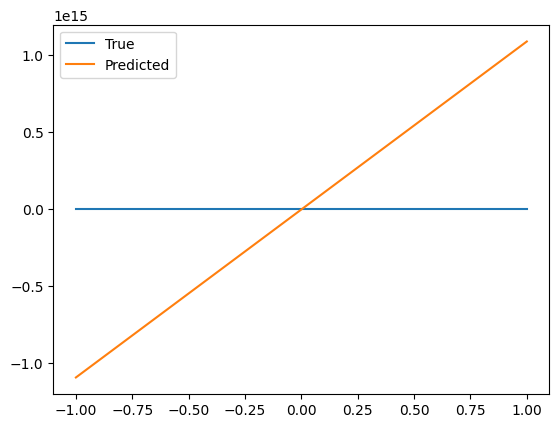

In [84]:
model.eval()
ran = np.random.randint(0, 100)
best_out, best_loss, best_func, best_indexes, best_params, stacked_preds, stacked_losses, all_params = model(input_data)
print(f"best_func: {best_func[ran]}")
print(f"best_loss: {best_loss[ran]}")
plt.plot(x_values.detach().cpu().numpy(), y_values[ran].detach().cpu().numpy(), label='True')
plt.plot(x_values.detach().cpu().numpy(), best_out[ran].detach().cpu().numpy(), label='Predicted')
plt.legend()